# Eindopdracht Data-Enginering Traject

In dit document zal ik middels verschillende data enginering technieken laten zien wat ik geleerd heb tijdens de cursus. Maar, voordat we verder gaan moeten we uiteraard eerst onze libraries inladen.

In [2]:
import os
from google.cloud import bigquery
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import datetime as dt
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
pd.options.display.max_rows = 20
np.set_printoptions(precision = 4, suppress = True)
%matplotlib inline

## Context

Ik ben momenteel werkzaam in marketing als Marketing Operations Specialist binnen de ecommerce, waarin ik mijzelf specialiseer in data-tracking. In het dagelijkse werkleven zijn er vaak verschillende vragen die opkomen vanuit onze data. Wij hebben de data sindskort gecentraliseerd in een Google BigQuery data warehouse, wat het mogelijk maakt om bepaalde vragen te beantwoorden. Belangrijke context:

* In de ecommerce staan de maanden november en december bekend als het 'peak season', doordat het de drukste periode van het jaar is.

*De data die we gebruiken komt rechtstreeks uit onze database. Ik heb voor veiligheidsredenen de anonymousId's gehasht.*

### Hoofdvraag 
In hoeverre zijn er inzichten te halen uit de rauwe data van het nieuwe datawarehouse?

#### Deelvragen
1. Wat is de verdeling van conversies per dag van de week per type conversie?
2. Hoeveel % van de gebruikers van 2021 heeft meerdere conversies gedaan?
3. Welke periode van het jaar levert de meeste conversies op per type conversie?
4. Is er een verband tussen het aantal touchpoints per gebruiker en de waarde van de conversie?

## De data querien vanuit de API

_Voor de controle hoeft dit niet gedaan te worden, dit heb ik zelf gedaan om de data in een DF te krijgen. Ik exporteer de data hierna in een CSV die daarna ingeladen wordt zodat het ook extern gedaan kan worden._

Zet het pad naar de serviceaccount credentials voor de API.

In [202]:
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="dreamdata-340610-84e4647eebc1.json"

Onderstaande query haalt alle events binnen van 2021.

In [203]:
# bqclient = bigquery.Client()

# # Download query results.
# query_string = """
# SELECT anonymousId, event, timestamp FROM dreamdata.sendcloud_com.events WHERE date(timestamp) BETWEEN '2021-01-01' AND '2021-12-31'
# """

# df = (
#     bqclient.query(query_string)
#     .result()
#     .to_dataframe(
#         create_bqstorage_client=True,
#     )
# )
# df.head()


## Data exporteren/importeren voor de eindopdracht
Om de opdracht te kunnen controlleren hashen we hier de waardes van anonymousId (als die niet 0 is) en slaan we die op in een csv.

In [166]:
# export_df = df[['anonymousId', 'event', 'timestamp']]
# export_df_false = export_df[export_df['anonymousId'].isna() == False]
# export_df_false['anonymousId'] = export_df_false['anonymousId'].apply(hash)
# export_df_true = export_df[export_df['anonymousId'].isna() == True]
# export_df_total = export_df_true.append(export_df_false)
# export_df_total.to_csv('dataset_rick_beijen.csv', index=False)

De data laden we hier in als DF:

In [201]:
df = pd.read_csv("https://www.dropbox.com/s/huymzn81yvxd094/dataset_rick_beijen.csv?dl=1")
df.head()

,anonymousId,event,timestamp
0,NaN,intercom_conversation_customer_initiated,2021-01-14 13:16:58+00:00
1,NaN,intercom_conversation_customer_initiated,2021-01-06 10:44:00+00:00
2,NaN,intercom_conversation_operator_initiated,2021-01-16 14:52:41+00:00
3,NaN,intercom_conversation_customer_initiated,2021-01-13 16:07:36+00:00
4,NaN,intercom_conversation_operator_initiated,2021-01-30 05:58:51+00:00


## Wat is de verdeling van conversies per dag van de week per type conversie?

Om te kunnen zien wat de verdeling per dag is, moeten er een aantal handelingen gebeuren:

1. Conversie events bekijken en opschonen
2. df filteren op conversie events 
3. Kolom 'dag' maken vanuit timestamp
4. Per dag een count maken van het aantal leads
5. Outliers detecteren
6. Data plotten

### Conversie events bekijken en opschonen

De conversie event die we gaan gebruiken zijn:

1. Downloaded content
2. Pricing List Download
3. Requested Demo

In [204]:
df['event'].unique()

array(['intercom_conversation_customer_initiated',
       'intercom_conversation_operator_initiated',
       'intercom_conversation_automated',
       'intercom_email_customer_initiated',
       'intercom_email_campaigns_initiated',
       'intercom_facebook_customer_initiated', 'intercom_email_automated',
       'intercom_conversation_admin_initiated',
       'intercom_email_admin_initiated', 'phone_call', 'email_replied',
       'meeting', 'Internal Lead Gen', 'email_clicked',
       'intercom_conversation_campaigns_initiated', 'page_view', 'VWO',
       'Experiment Viewed', 'downloaded content',
       'pricing list downloaded', 'Clicked Research Report',
       'requested demo', 'Pricing List Downloaded', 'contact form sales',
       'requested marketplace', 'webinar signup', 'Played Video',
       'Checklist Shown (Appcues)', 'Flow Skipped (Appcues)',
       'Flow Started (Appcues)', 'Step Started (Appcues)',
       'Step Interacted (Appcues)', 'Step Skipped (Appcues)',
       'Ac

Zoals we zien zijn er meerdere benamingen voor de conversies, zoals downloaded content en content download. Deze moeten we samenvoegen.

In [205]:
df['event'].replace('content download', 'downloaded content', inplace=True)
df['event'].replace('prices download', 'pricing list downloaded', inplace=True)
df['event'].replace('Pricing List Downloaded', 'pricing list downloaded', inplace=True)
df['event'].replace('Requested Demo', 'requested demo', inplace=True)
df['event'].unique()

array(['intercom_conversation_customer_initiated',
       'intercom_conversation_operator_initiated',
       'intercom_conversation_automated',
       'intercom_email_customer_initiated',
       'intercom_email_campaigns_initiated',
       'intercom_facebook_customer_initiated', 'intercom_email_automated',
       'intercom_conversation_admin_initiated',
       'intercom_email_admin_initiated', 'phone_call', 'email_replied',
       'meeting', 'Internal Lead Gen', 'email_clicked',
       'intercom_conversation_campaigns_initiated', 'page_view', 'VWO',
       'Experiment Viewed', 'downloaded content',
       'pricing list downloaded', 'Clicked Research Report',
       'requested demo', 'contact form sales', 'requested marketplace',
       'webinar signup', 'Played Video', 'Checklist Shown (Appcues)',
       'Flow Skipped (Appcues)', 'Flow Started (Appcues)',
       'Step Started (Appcues)', 'Step Interacted (Appcues)',
       'Step Skipped (Appcues)', 'Account Created',
       'Step Compl

Zoals we kunnen zien zijn de overtollige events opgeschoond.

### DF filteren op conversie events 

De data zit nog vol met overtollige datapunten, we zien nu alleen benieuwd naar de conversie events, dus die moeten eruit gefilterd worden.

In [206]:
df_leads = df[(df['event'] == 'downloaded content')|(df['event'] == 'pricing list downloaded')|(df['event'] == 'requested demo')]
df_leads.head()

,anonymousId,event,timestamp
332196,9.781566e+17,downloaded content,2021-01-08 23:51:17.693000+00:00
332254,3.306186e+18,downloaded content,2021-01-24 05:21:42.350000+00:00
332259,7.645386e+18,downloaded content,2021-01-04 19:03:58.518000+00:00
332281,8.212032e+18,downloaded content,2021-01-11 01:40:26.873000+00:00
332291,4.364489e+18,downloaded content,2021-01-19 09:11:52.407000+00:00


### Kolom 'dag' maken vanuit timestamp

Timestamp naar datetime en vervolgens casten naar dag.

In [207]:
df_leads['timestamp'] = pd.to_datetime(df_leads['timestamp'])
df_leads['day'] = df_leads['timestamp'].dt.day_name()
df_leads.head()

,anonymousId,event,timestamp,day
332196,9.781566e+17,downloaded content,2021-01-08 23:51:17.693000+00:00,Friday
332254,3.306186e+18,downloaded content,2021-01-24 05:21:42.350000+00:00,Sunday
332259,7.645386e+18,downloaded content,2021-01-04 19:03:58.518000+00:00,Monday
332281,8.212032e+18,downloaded content,2021-01-11 01:40:26.873000+00:00,Monday
332291,4.364489e+18,downloaded content,2021-01-19 09:11:52.407000+00:00,Tuesday


### Per dag een count maken van het aantal leads

Middels de groupby statement.

In [208]:
df_leads_day = df_leads.groupby(['day'])[['event']].count()
df_leads_day

,event
day,
Friday,9873
Monday,10482
Saturday,7483
Sunday,8112
Thursday,10359
Tuesday,10593
Wednesday,10863


### Outliers detecteren

Door de data te groeperen per timestamp kunnen we de statistische gegevens analyseren.

In [209]:
df_leads['timestamp'] = df_leads['timestamp'].dt.date
df_leads['timestamp']

332196     2021-01-08
332254     2021-01-24
332259     2021-01-04
332281     2021-01-11
332291     2021-01-19
              ...    
8641962    2021-09-07
8641968    2021-09-06
8641972    2021-09-13
8641973    2021-09-13
8642001    2021-09-04
Name: timestamp, Length: 67765, dtype: object

Nu kunnen we de data groeperen op de datum en het aantal conversies.

In [210]:
df_leads_date = df_leads.groupby([df_leads['timestamp']])[['event']].count()
df_leads_date

,event
timestamp,
2021-01-01,191
2021-01-02,225
2021-01-03,204
2021-01-04,251
2021-01-05,248
...,...
2021-12-27,172
2021-12-28,166
2021-12-29,169


We maken een boxplot van de data om de verdeling te zien en de outliers te detecteren.

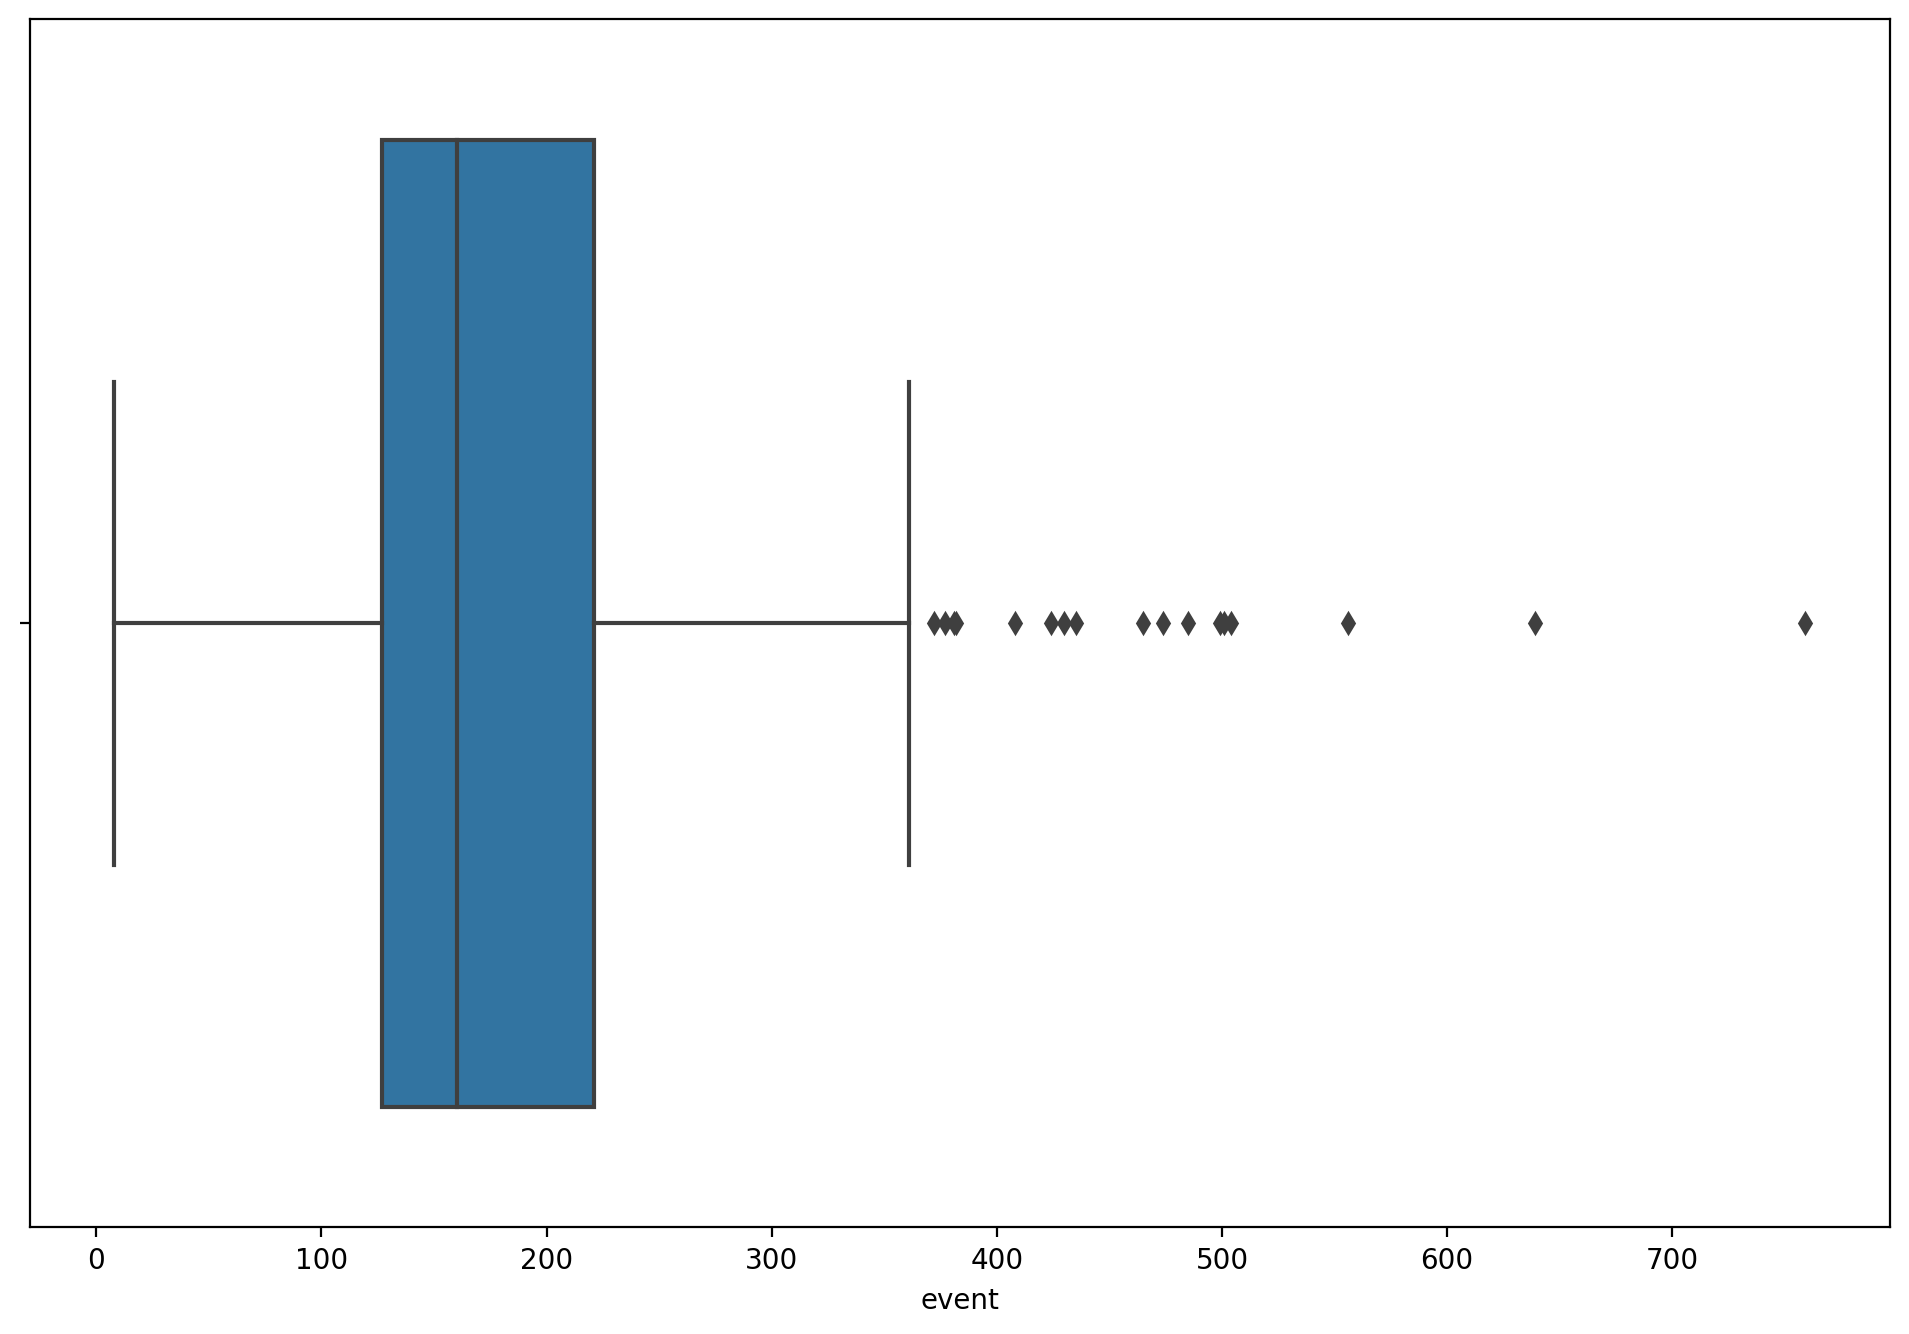

In [211]:
sns.boxplot(x='event',data = df_leads_date);

We beschrijven de data om nog een beter beeld te krijgen bij de statistieken.

In [212]:
df_leads_date.describe()

,event
count,365.000000
mean,185.657534
std,92.374658
min,8.000000
25%,127.000000
50%,160.000000
75%,221.000000
max,759.000000


We zien dat de dataset verschillende outliers aangeeft. Dit zijn outliers die ongeveer meer dan 380 leads hebben, die gaan we nu isoleren.

In [213]:
df_leads_date[df_leads_date['event'] >380]

,event
timestamp,
2021-11-02,382
2021-11-10,381
2021-11-24,465
2021-11-25,759
2021-11-26,639
2021-11-29,556
2021-11-30,424
2021-12-01,430
2021-12-02,435


Alle outliers vinden plaats in november en december van het jaar. In de E-commerce zijn dit de drukste dagen en wordt het ook wel het peak-season genoemd. Hierdoor kan er geconcludeerd worden dat deze outliers valide zijn en dus meegenomen kunnen worden. Wel is het goed om de plot met en zonder outliers te maken om het verschil te zien.

### Selectie maken zonder outliers
Hiervoor moeten we eerst de data opnieuw verrijken met een dag kolom op basis van de timestamp. We filteren de datums eruit die meer dan 380 conversies hebben.

In [214]:
df_leads_date['day'] = df_leads_date.index
df_leads_date['day'] = pd.to_datetime(df_leads_date['day'])
df_leads_date['day'] = df_leads_date['day'].dt.day_name()
df_leads_date_clean = df_leads_date[df_leads_date['event']<380]
df_leads_date_clean

,event,day
timestamp,,
2021-01-01,191,Friday
2021-01-02,225,Saturday
2021-01-03,204,Sunday
2021-01-04,251,Monday
2021-01-05,248,Tuesday
...,...,...
2021-12-27,172,Monday
2021-12-28,166,Tuesday
2021-12-29,169,Wednesday


Tekst.

In [215]:
df_leads_date_clean = df_leads_date_clean.groupby(['day'])[['event']].sum()
df_leads_date_clean

,event
day,
Friday,8234
Monday,9926
Saturday,7009
Sunday,7608
Thursday,8680
Tuesday,9787
Wednesday,9179


###  Data plotten
We plotten de data in de subplots naast elkaar om duidelijk het verschil te kunnen zien.

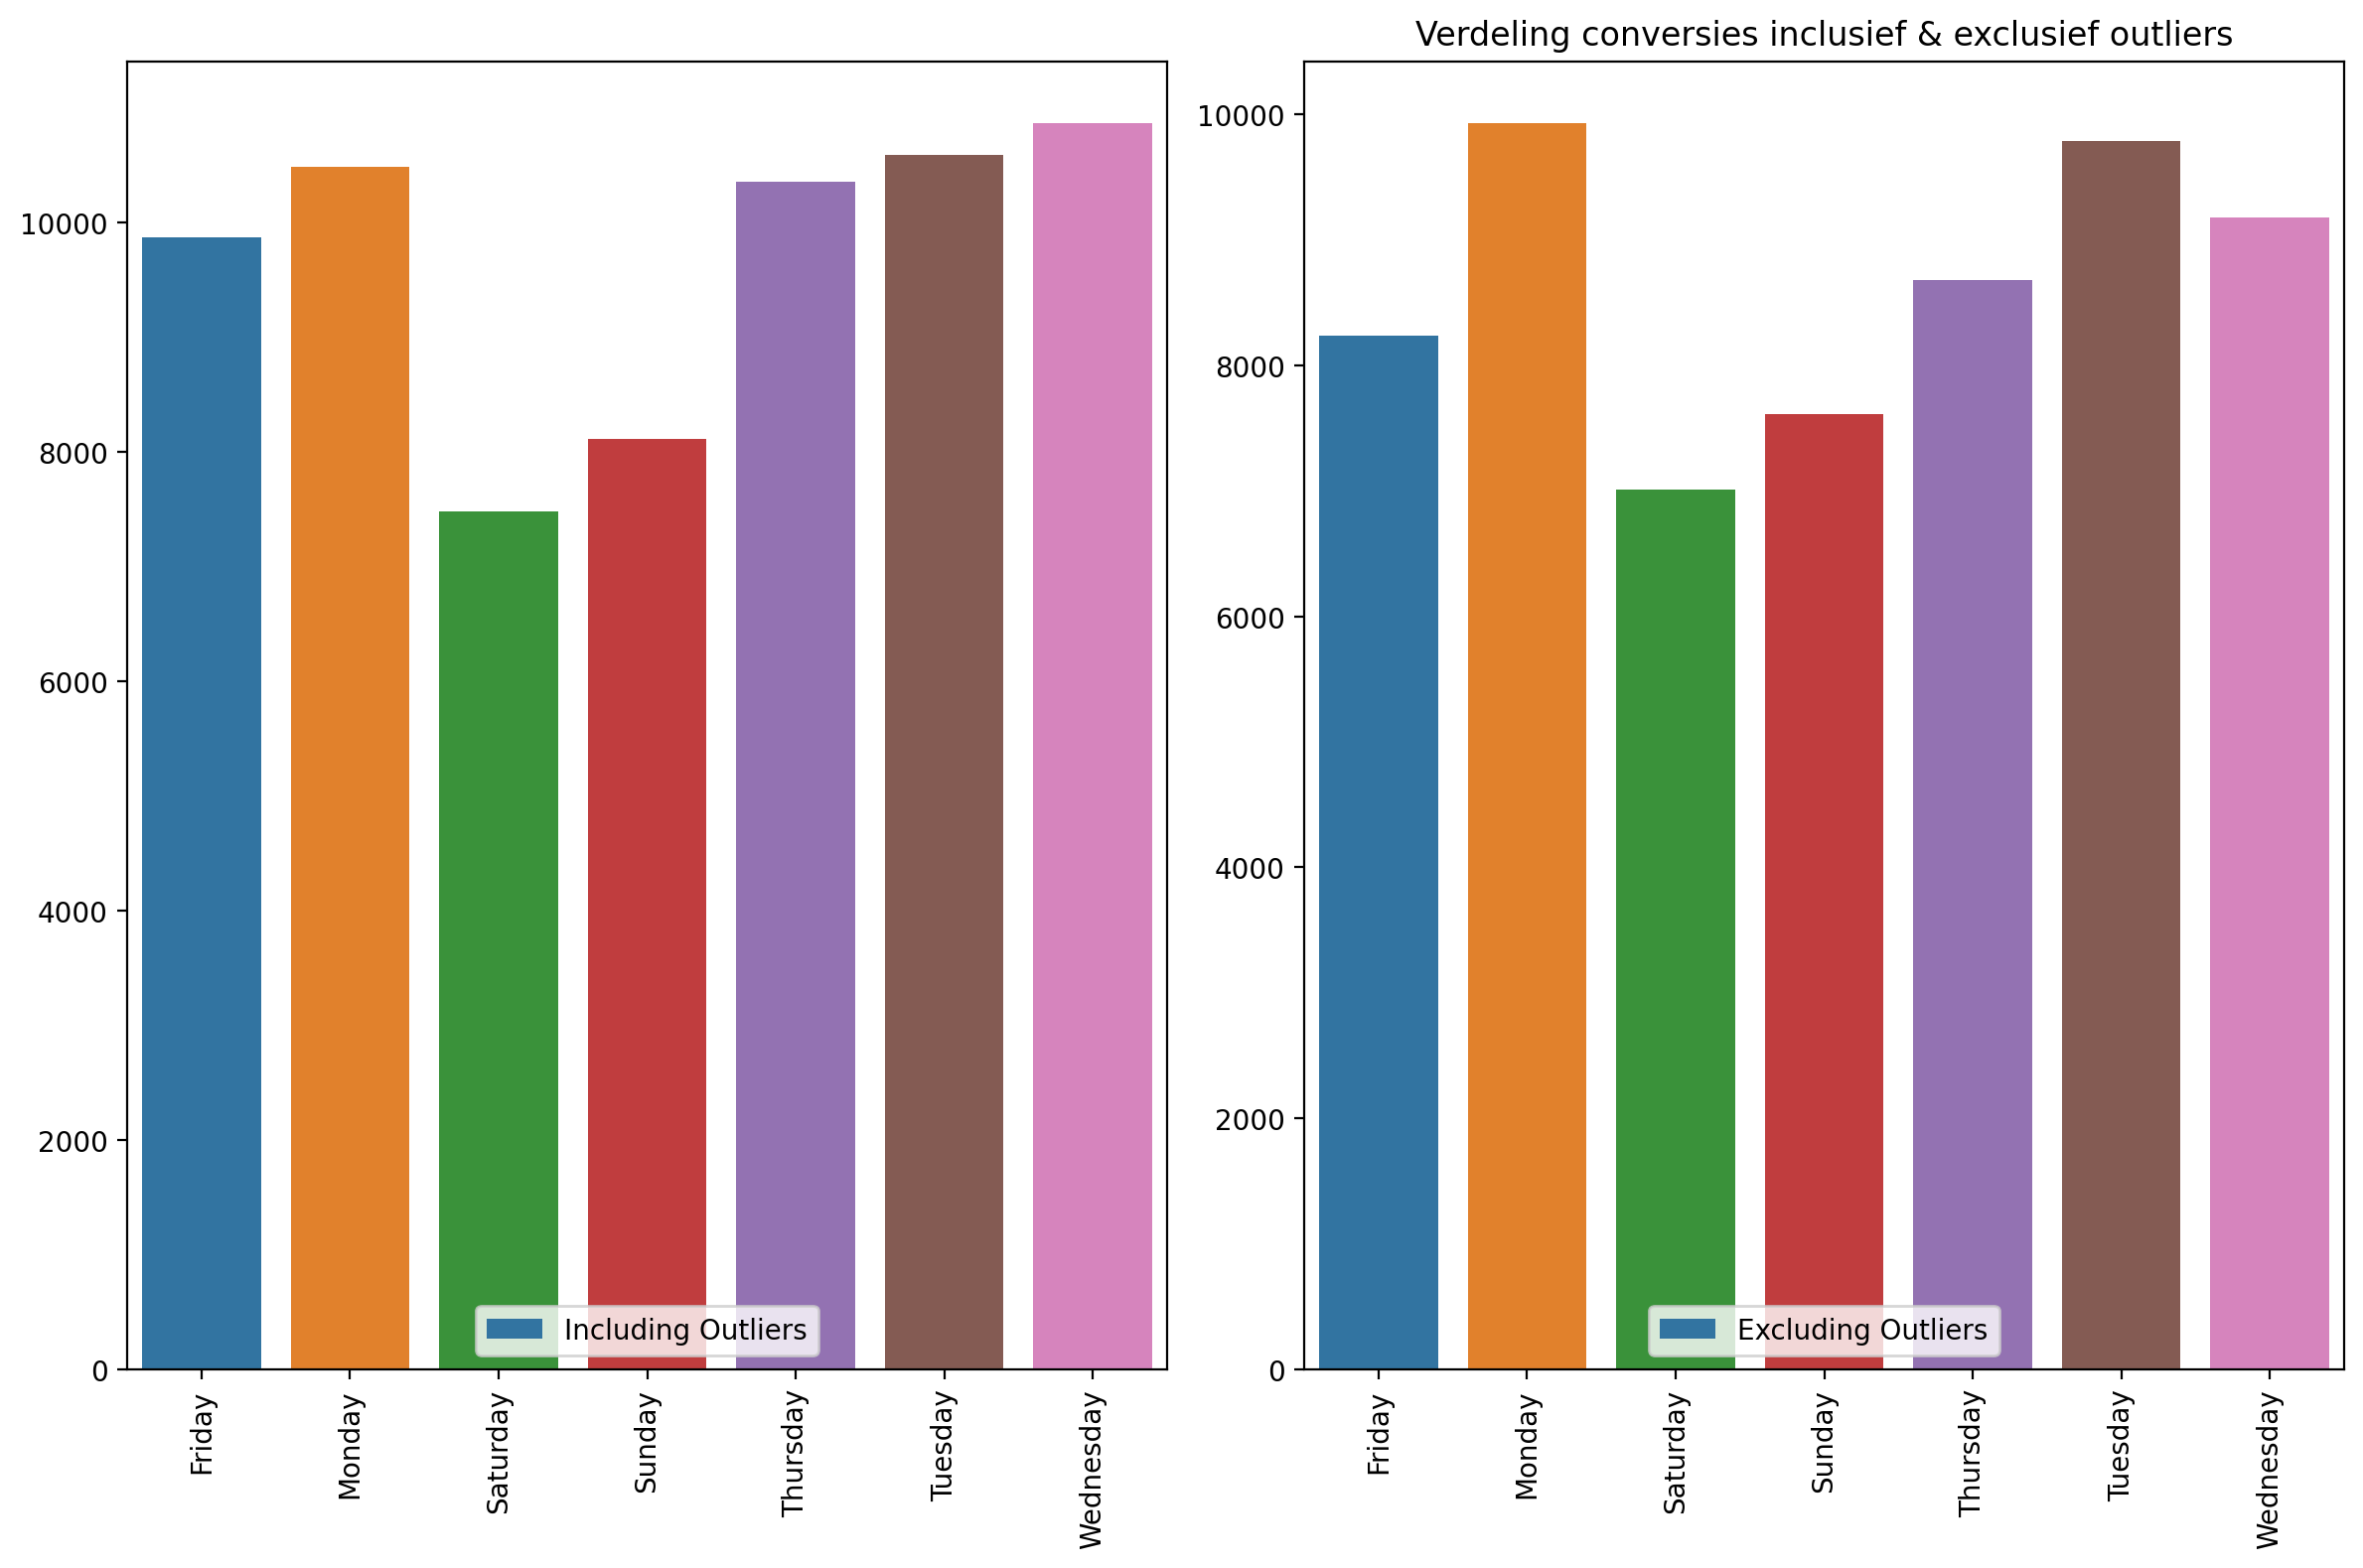

In [216]:
fig, ax = plt.subplots(nrows=1, ncols=2)
sns.barplot(x=df_leads_day.index, y = 'event', data = df_leads_day, ax = ax[0], label = "Including Outliers");
sns.barplot(x=df_leads_date_clean.index, y = 'event', data = df_leads_date_clean, ax=ax[1], label = "Excluding Outliers");
ax[0].set_xticklabels(df_leads_day.index, rotation= 90 );
ax[1].set_xticklabels(df_leads_day.index, rotation= 90 );
plt.title("Verdeling conversies inclusief & exclusief outliers");
ax[0].set(xlabel=None, ylabel = None);
ax[1].set(xlabel=None, ylabel = None);
ax[0].legend(loc="lower center");
ax[1].legend(loc="lower center");
fig.tight_layout()
plt.show()

#### Verdeling per type conversie
Hierbij kiezen we ervoor om de outliers te betrekkenm wegens simpelweg de reden dat het mij niet lukte om een goede split te maken zonder outliers. Voor vervolgonderzoek kan er nog verder gesegmenteerd worden in de data.

In [217]:
df_group_event = df_leads.groupby(['event','day'])['event'].count().to_frame()
df_group_event.rename(columns={"event": 'count'}, inplace=True)
df_group_event = df_group_event.reset_index()
df_group_event

,event,day,count
0,downloaded content,Friday,4081
1,downloaded content,Monday,4061
2,downloaded content,Saturday,2996
3,downloaded content,Sunday,3275
4,downloaded content,Thursday,4087
...,...,...,...
16,requested demo,Saturday,241
17,requested demo,Sunday,249
18,requested demo,Thursday,513
19,requested demo,Tuesday,636


We maken de barplot op de dag, de count van de conversies en we maken een hue van het type event.

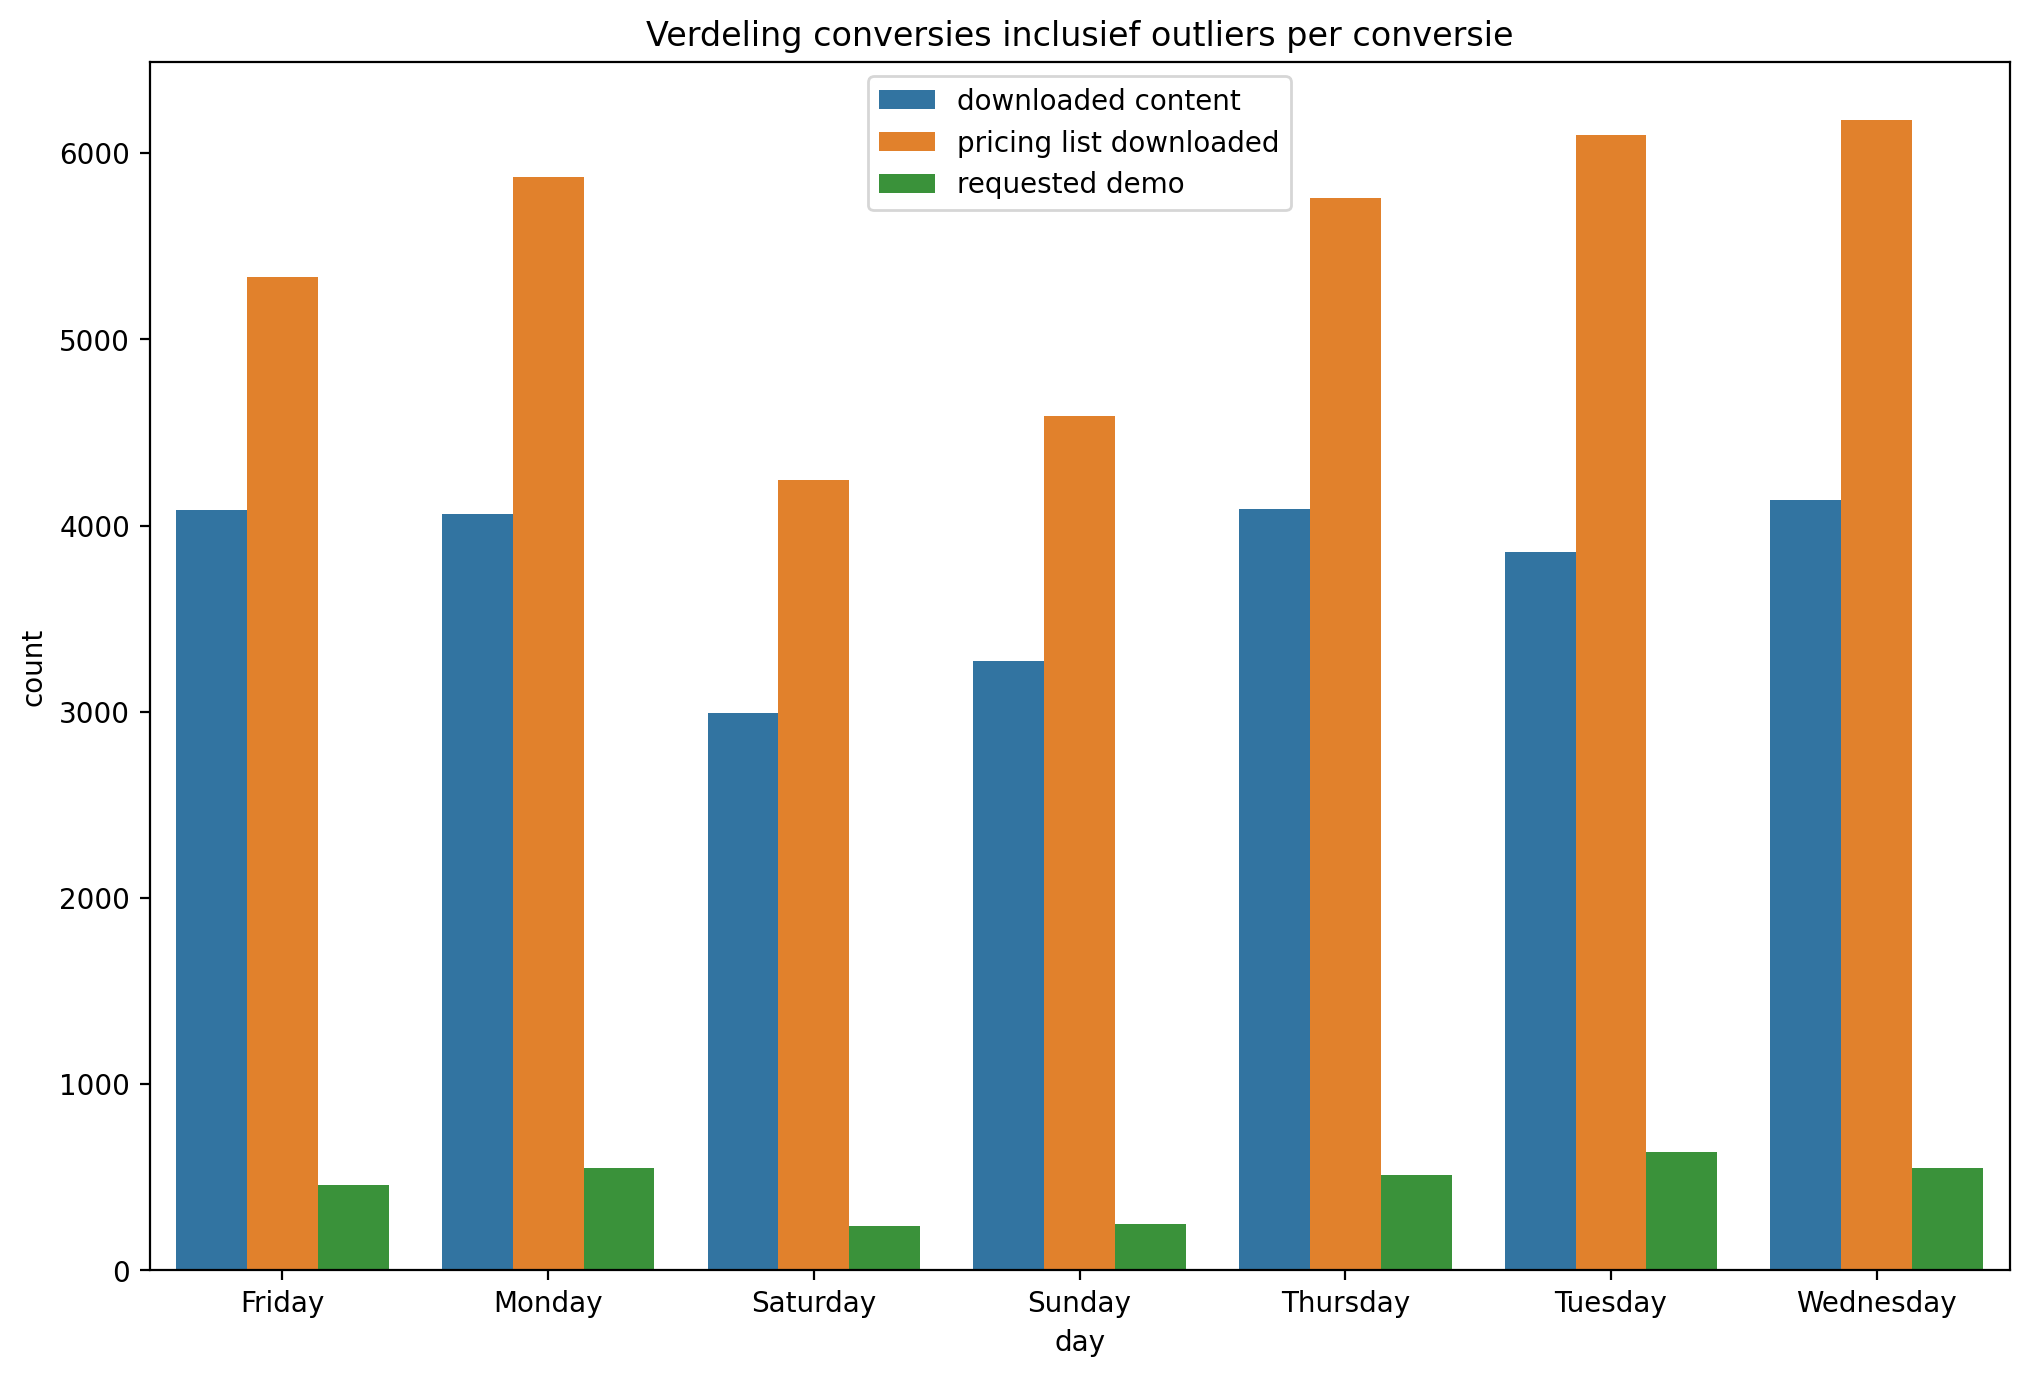

In [218]:
sns.barplot(x='day', y = 'count', data = df_group_event, hue = 'event');
plt.title("Verdeling conversies inclusief outliers per conversie");
fig.tight_layout()
plt.legend(loc="upper center")
plt.show()

En alles samen:

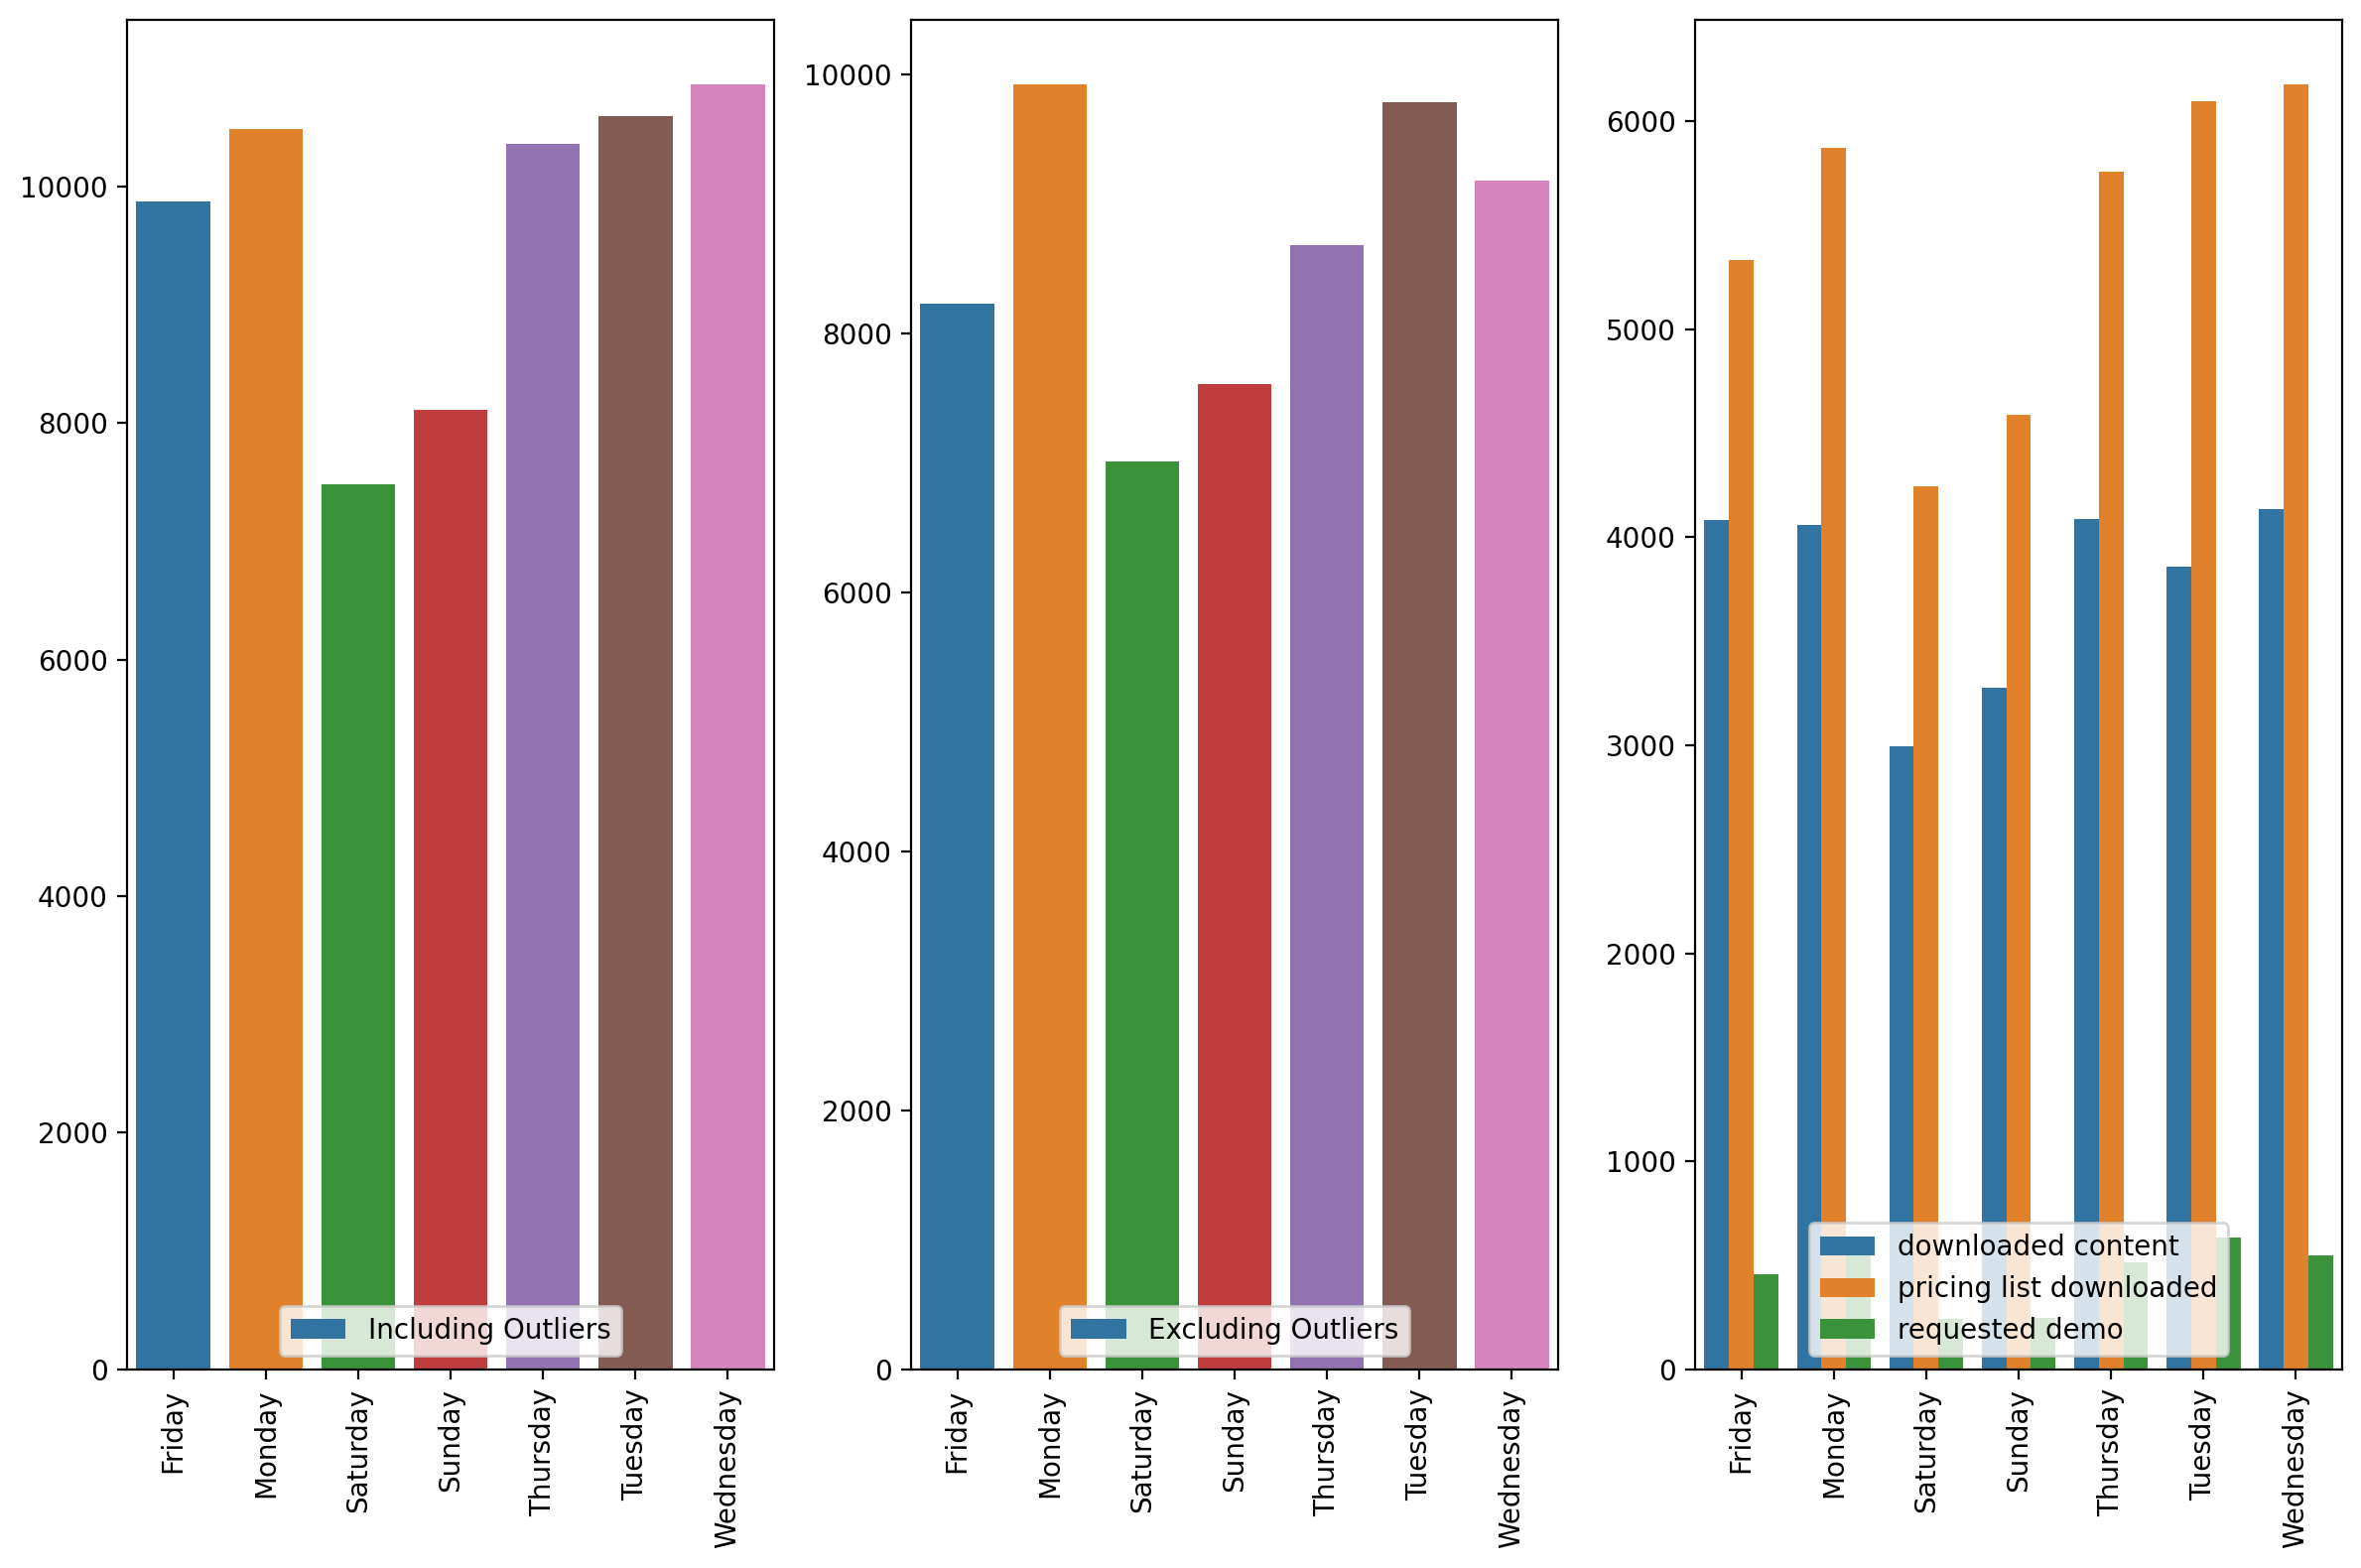

In [219]:
fig, ax = plt.subplots(nrows=1, ncols=3)
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200 
sns.barplot(x=df_leads_day.index, y = 'event', data = df_leads_day, ax = ax[0], label = "Including Outliers");
sns.barplot(x=df_leads_date_clean.index, y = 'event', data = df_leads_date_clean, ax=ax[1], label = "Excluding Outliers");
sns.barplot(x='day', y = 'count', data = df_group_event, hue = 'event', ax = ax[2]);
ax[0].set_xticklabels(df_leads_day.index, rotation= 90 );
ax[1].set_xticklabels(df_leads_day.index, rotation= 90 );
ax[2].set_xticklabels(df_leads_day.index, rotation= 90 );
ax[0].set(xlabel=None, ylabel = None);
ax[1].set(xlabel=None, ylabel = None);
ax[2].set(xlabel=None, ylabel = None);
ax[0].legend(loc="lower center");
ax[1].legend(loc="lower center");
ax[2].legend(loc="lower center");
fig.tight_layout()
plt.show()

### Antwoord op de vraag

We zien een verschil tussen wel/niet outliers. Bij de data met outliers is de beste dag woensdag, echter in de data zonder outliers is de beste dag maandag. Wel is er overduidelijk een voorkeur voor de eerste helft van de week en een overduidelijke drop in het weekend. Opvallend in de split per type conversie is te zien dat prijslijst downloads alleen een dip in het weekend heeft en de rest van de dagen stabiel loopt. De overige conversies zijn in lijn met de hoofdtrend.

## Hoeveel % van de gebruikers van 2021 heeft meerdere conversies gedaan?

Hiervoor gebruiken we de kolom anonymousId, waarbij we er vanuit gaan dat deze gelijk is voor dezelfde user met alle events.

Om te kunnen zien wat de verdeling per dag is, moeten er een aantal handelingen gebeuren:

1. NA Values detecteren
2. NA verwijderen
3. Selectie maken
4. Plotten

### Eerst gaan we kijken of er NA values zijn.

We printen eerst de lengte van het dataframe om aan het einde te kunnen vergelijken.

In [220]:
len(df)

8642074

Nu gaan we kijken of er NA values zijn.

In [221]:
len(df[df['anonymousId'].isna()])

332156

We zien flink wat rijen met lege anonymousId. Om een beter beeld te krijgen bij deze datapunten gaan we ze isoleren.

In [222]:
df[df['anonymousId'].isna()].event.unique()

array(['intercom_conversation_customer_initiated',
       'intercom_conversation_operator_initiated',
       'intercom_conversation_automated',
       'intercom_email_customer_initiated',
       'intercom_email_campaigns_initiated',
       'intercom_facebook_customer_initiated', 'intercom_email_automated',
       'intercom_conversation_admin_initiated',
       'intercom_email_admin_initiated', 'phone_call', 'email_replied',
       'meeting', 'Internal Lead Gen', 'email_clicked',
       'intercom_conversation_campaigns_initiated'], dtype=object)

Aan de kolommen te zien zijn het datapunten van bepaalde tools die geen conversies meten voor ons. Deze kunnen we veilig droppen uit de dataset voor de analyse.

In [223]:
df_id_clean = df.drop(df[df['anonymousId'].isna()].index)
df_id_clean

,anonymousId,event,timestamp
332156,-1.965377e+18,page_view,2021-01-09 13:44:19.485000+00:00
332157,-3.341005e+18,page_view,2021-01-21 12:18:32.209000+00:00
332158,-1.303344e+18,page_view,2021-01-17 18:53:14.744000+00:00
332159,-5.560603e+18,page_view,2021-01-30 18:04:35.393000+00:00
332160,-8.479270e+18,page_view,2021-01-10 02:43:36.748000+00:00
...,...,...,...
8642069,-6.993853e+18,page_view,2021-09-02 14:44:27.426000+00:00
8642070,-4.995560e+18,page_view,2021-09-01 15:25:23.141000+00:00
8642071,-7.403779e+18,page_view,2021-09-03 10:23:33.797000+00:00
8642072,-5.786839e+18,page_view,2021-09-06 08:26:10.778000+00:00


## We maken een selectie voor de piechart
Op basis van de conversies.

In [224]:
df_id = df_id_clean[(df_id_clean['event'] == 'downloaded content')|(df_id_clean['event'] == 'pricing list downloaded')|(df_id_clean['event'] == 'requested demo')]
df_id

,anonymousId,event,timestamp
332196,9.781566e+17,downloaded content,2021-01-08 23:51:17.693000+00:00
332254,3.306186e+18,downloaded content,2021-01-24 05:21:42.350000+00:00
332259,7.645386e+18,downloaded content,2021-01-04 19:03:58.518000+00:00
332281,8.212032e+18,downloaded content,2021-01-11 01:40:26.873000+00:00
332291,4.364489e+18,downloaded content,2021-01-19 09:11:52.407000+00:00
...,...,...,...
8641962,-7.706742e+18,downloaded content,2021-09-07 07:01:49.552000+00:00
8641968,4.084460e+18,downloaded content,2021-09-06 16:23:51.130000+00:00
8641972,4.601690e+18,downloaded content,2021-09-13 04:32:26.724000+00:00
8641973,4.601690e+18,downloaded content,2021-09-13 04:32:26.418000+00:00


We groeperen de data voor de piechart.

In [225]:
df_grouped = df_id.groupby('anonymousId')[['event']].count()
df_grouped

,event
anonymousId,
-9.223258e+18,1
-9.223077e+18,1
-9.222939e+18,1
-9.222835e+18,2
-9.222080e+18,1
...,...
9.221444e+18,1
9.222265e+18,1
9.222541e+18,1


## En we plotten de code
Hiervoor gebruiken we een Piechart.

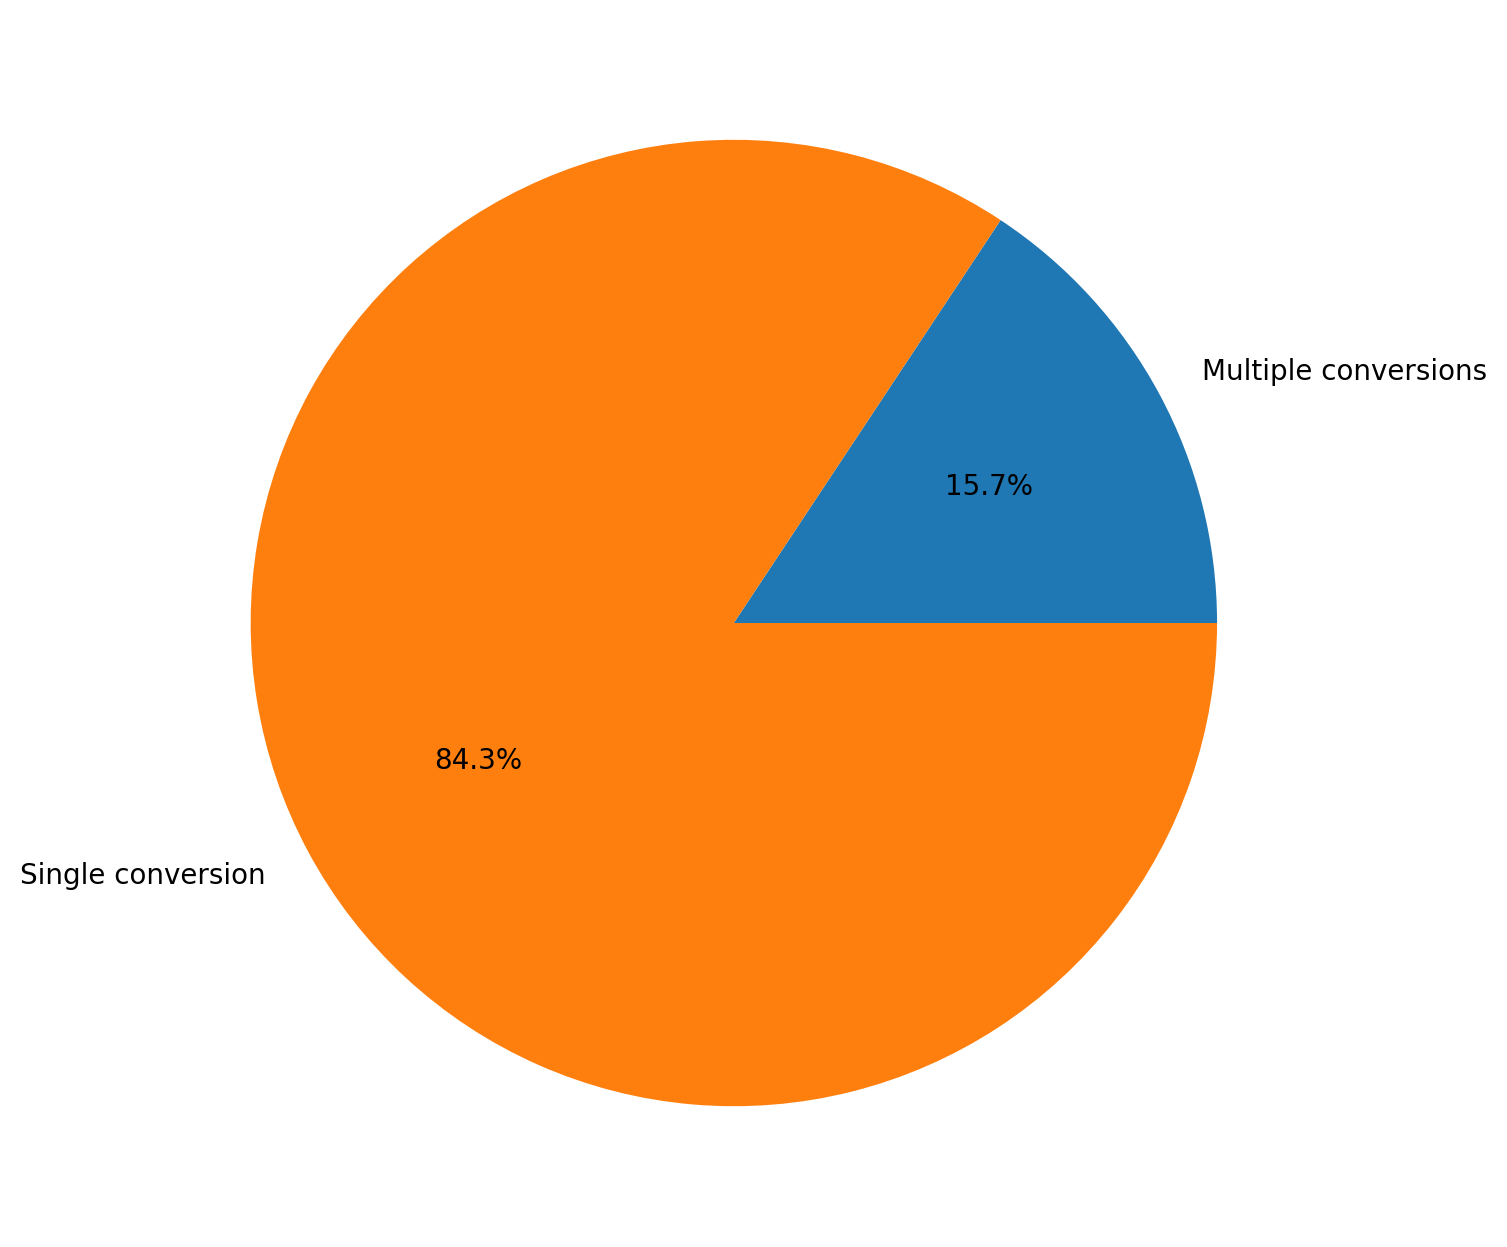

In [226]:
pieList = [df_grouped[df_grouped['event'] > 1].count()[0], df_grouped[df_grouped['event'] == 1].count()[0]]
labels = ['Multiple conversions', 'Single conversion']
plt.pie(pieList, labels=labels, autopct='%1.1f%%');

### Antwoord op de vraag

15,7% van het totaal heeft meerdere conversies gedaan. Hieruit is een aanname te stellen dat de meerderheid van onze conversies 'one-offs' zijn en ze niet verder geïnteresseerd zijn. Advies voor vervolg hiero is om deze split per type conversie te maken om zien of de one-offs de hogere waarde conversies (prijslijst, demo) zijn on de lagere (content download).

## 3. Welke periode van het jaar levert de meeste conversies op per type conversie?

In [227]:
df_group_event_out = df_leads.groupby(['timestamp'])['event'].count().to_frame()
df_group_event_noOut = df_leads.groupby(['timestamp', 'event'])['event'].count().to_frame()
df_group_event_noOut = df_group_event_noOut.rename(columns={'event': "count"})
df_group_event_noOut = df_group_event_noOut.reset_index()
df_group_event_noOut

,timestamp,event,count
0,2021-01-01,downloaded content,120
1,2021-01-01,pricing list downloaded,67
2,2021-01-01,requested demo,4
3,2021-01-02,downloaded content,115
4,2021-01-02,pricing list downloaded,101
...,...,...,...
1081,2021-12-30,downloaded content,77
1082,2021-12-30,pricing list downloaded,121
1083,2021-12-30,requested demo,5
1084,2021-12-31,downloaded content,46


Nu kunnen we de data plotten in een lineplot.

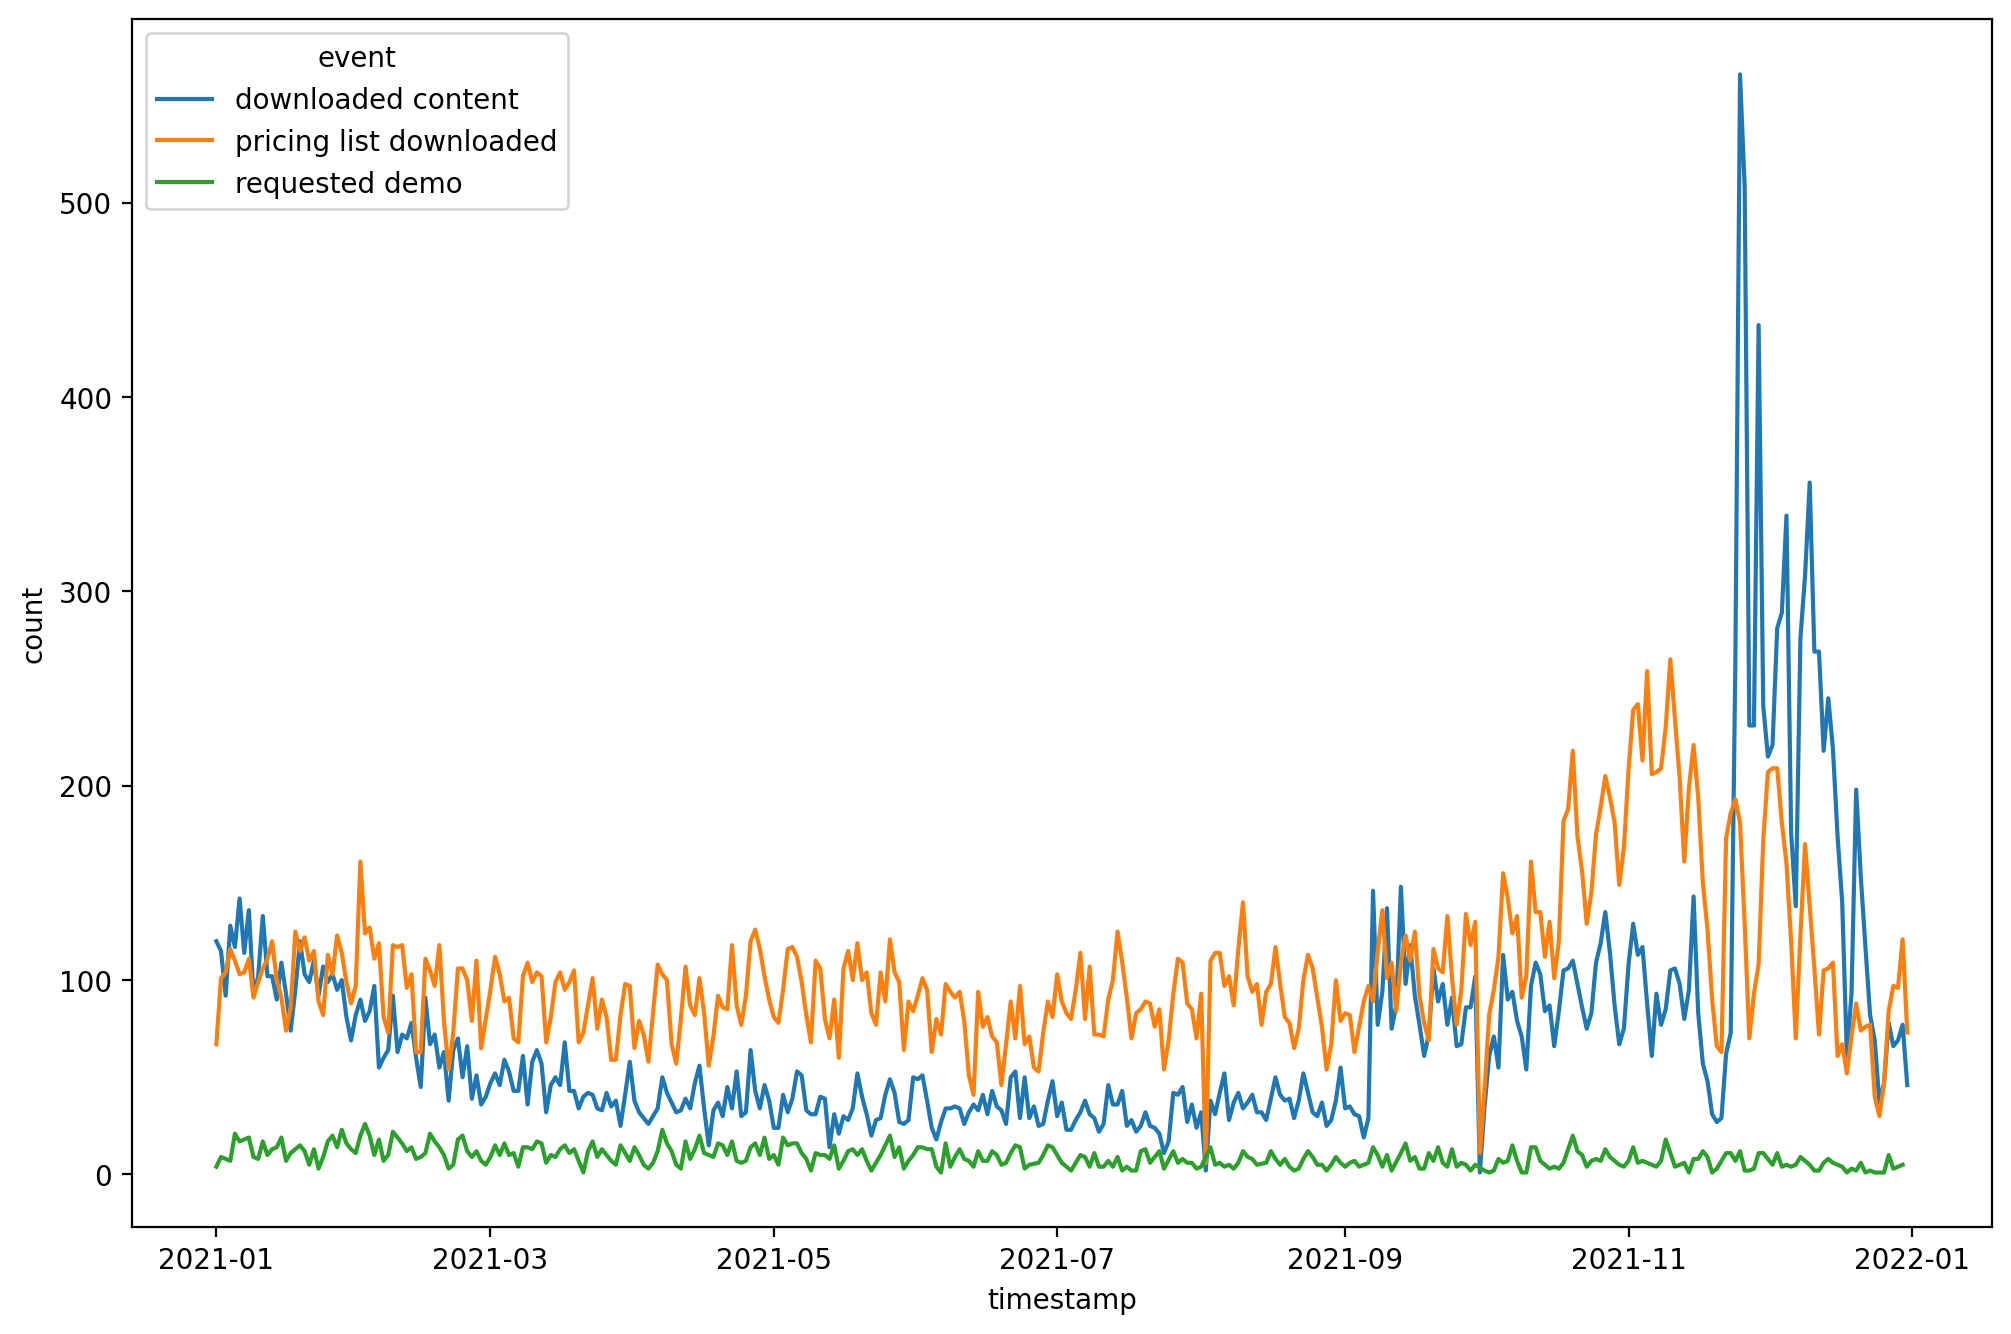

In [228]:
sns.lineplot(x = 'timestamp', y='count', data = df_group_event_noOut, hue = 'event');

## Antwoord op de vraag

We zien vergelijkbaar gedrag Pricing List Downloads en Content Downloads, waarbij er voor allebei een dip is in de voorjaar- en zomermaanden, maar een enorme piek vanaf oktober/november. Dit is in lijn met het 'peakseason' van ecommerce. Interessante is wel dat Pricing List Downloads een maand eerder al flink pieken om vervolgens in november helemaal omhoog te schieten. Hieruit kunnen we een aanname maken dat potentiele klanten in september al bezig zijn met hun verzendsysteem voor te bereiden op het peakseason. Hier kan op ingespeeld worden met de marketing.

## Is er een verband tussen het aantal touchpoints per gebruiker en de waarde van de conversie?

Voor deze analyse gaan we van de volgende waardes uit:
* Downloaded Content = 50
* Pricing List Downloaded = 100
* Requested Demo = 120

Ook bij deze analyse gaan we er vanuit dat de kolom anonymousId gelijk is voor dezelfde user met alle events. We hebben deze selectie al gemaakt, dus we kunnen het dataframe df_id_clean gebruiken:

In [229]:
df_id_clean

,anonymousId,event,timestamp
332156,-1.965377e+18,page_view,2021-01-09 13:44:19.485000+00:00
332157,-3.341005e+18,page_view,2021-01-21 12:18:32.209000+00:00
332158,-1.303344e+18,page_view,2021-01-17 18:53:14.744000+00:00
332159,-5.560603e+18,page_view,2021-01-30 18:04:35.393000+00:00
332160,-8.479270e+18,page_view,2021-01-10 02:43:36.748000+00:00
...,...,...,...
8642069,-6.993853e+18,page_view,2021-09-02 14:44:27.426000+00:00
8642070,-4.995560e+18,page_view,2021-09-01 15:25:23.141000+00:00
8642071,-7.403779e+18,page_view,2021-09-03 10:23:33.797000+00:00
8642072,-5.786839e+18,page_view,2021-09-06 08:26:10.778000+00:00


Nu kunnen we de waardes van de conversies mappen naar een nieuwe kolom.

In [230]:
dict_values = {'pricing list downloaded': 100, 'downloaded content': 50, 'requested demo': 120}
df_id_clean['value'] = df_id_clean['event']
df_id_clean['value'] = df_id_clean['value'].map(dict_values)
df_id_clean

,anonymousId,event,timestamp,value
332156,-1.965377e+18,page_view,2021-01-09 13:44:19.485000+00:00,NaN
332157,-3.341005e+18,page_view,2021-01-21 12:18:32.209000+00:00,NaN
332158,-1.303344e+18,page_view,2021-01-17 18:53:14.744000+00:00,NaN
332159,-5.560603e+18,page_view,2021-01-30 18:04:35.393000+00:00,NaN
332160,-8.479270e+18,page_view,2021-01-10 02:43:36.748000+00:00,NaN
...,...,...,...,...
8642069,-6.993853e+18,page_view,2021-09-02 14:44:27.426000+00:00,NaN
8642070,-4.995560e+18,page_view,2021-09-01 15:25:23.141000+00:00,NaN
8642071,-7.403779e+18,page_view,2021-09-03 10:23:33.797000+00:00,NaN
8642072,-5.786839e+18,page_view,2021-09-06 08:26:10.778000+00:00,NaN


Nu kunnen we de NaN values vervangen met 0.

In [231]:
df_id_clean['value'] = df_id_clean['value'].fillna(0)
df_id_clean

,anonymousId,event,timestamp,value
332156,-1.965377e+18,page_view,2021-01-09 13:44:19.485000+00:00,0.0
332157,-3.341005e+18,page_view,2021-01-21 12:18:32.209000+00:00,0.0
332158,-1.303344e+18,page_view,2021-01-17 18:53:14.744000+00:00,0.0
332159,-5.560603e+18,page_view,2021-01-30 18:04:35.393000+00:00,0.0
332160,-8.479270e+18,page_view,2021-01-10 02:43:36.748000+00:00,0.0
...,...,...,...,...
8642069,-6.993853e+18,page_view,2021-09-02 14:44:27.426000+00:00,0.0
8642070,-4.995560e+18,page_view,2021-09-01 15:25:23.141000+00:00,0.0
8642071,-7.403779e+18,page_view,2021-09-03 10:23:33.797000+00:00,0.0
8642072,-5.786839e+18,page_view,2021-09-06 08:26:10.778000+00:00,0.0


Vervolgens aggegreren we de data per ID en count van het aantal touchpoints en de som van de waardes.

In [232]:
df_value = df_id_clean.groupby(['anonymousId']).agg({'event':['count'], 'value': ['sum']}).reset_index()

De waarde van 0 gooien we weg omdat het niet van toegevoegde waarde is voor onze analyse.

In [233]:
df_value = df_value[df_value['value']['sum'] != 0]

Vervolgens plotten we de data.

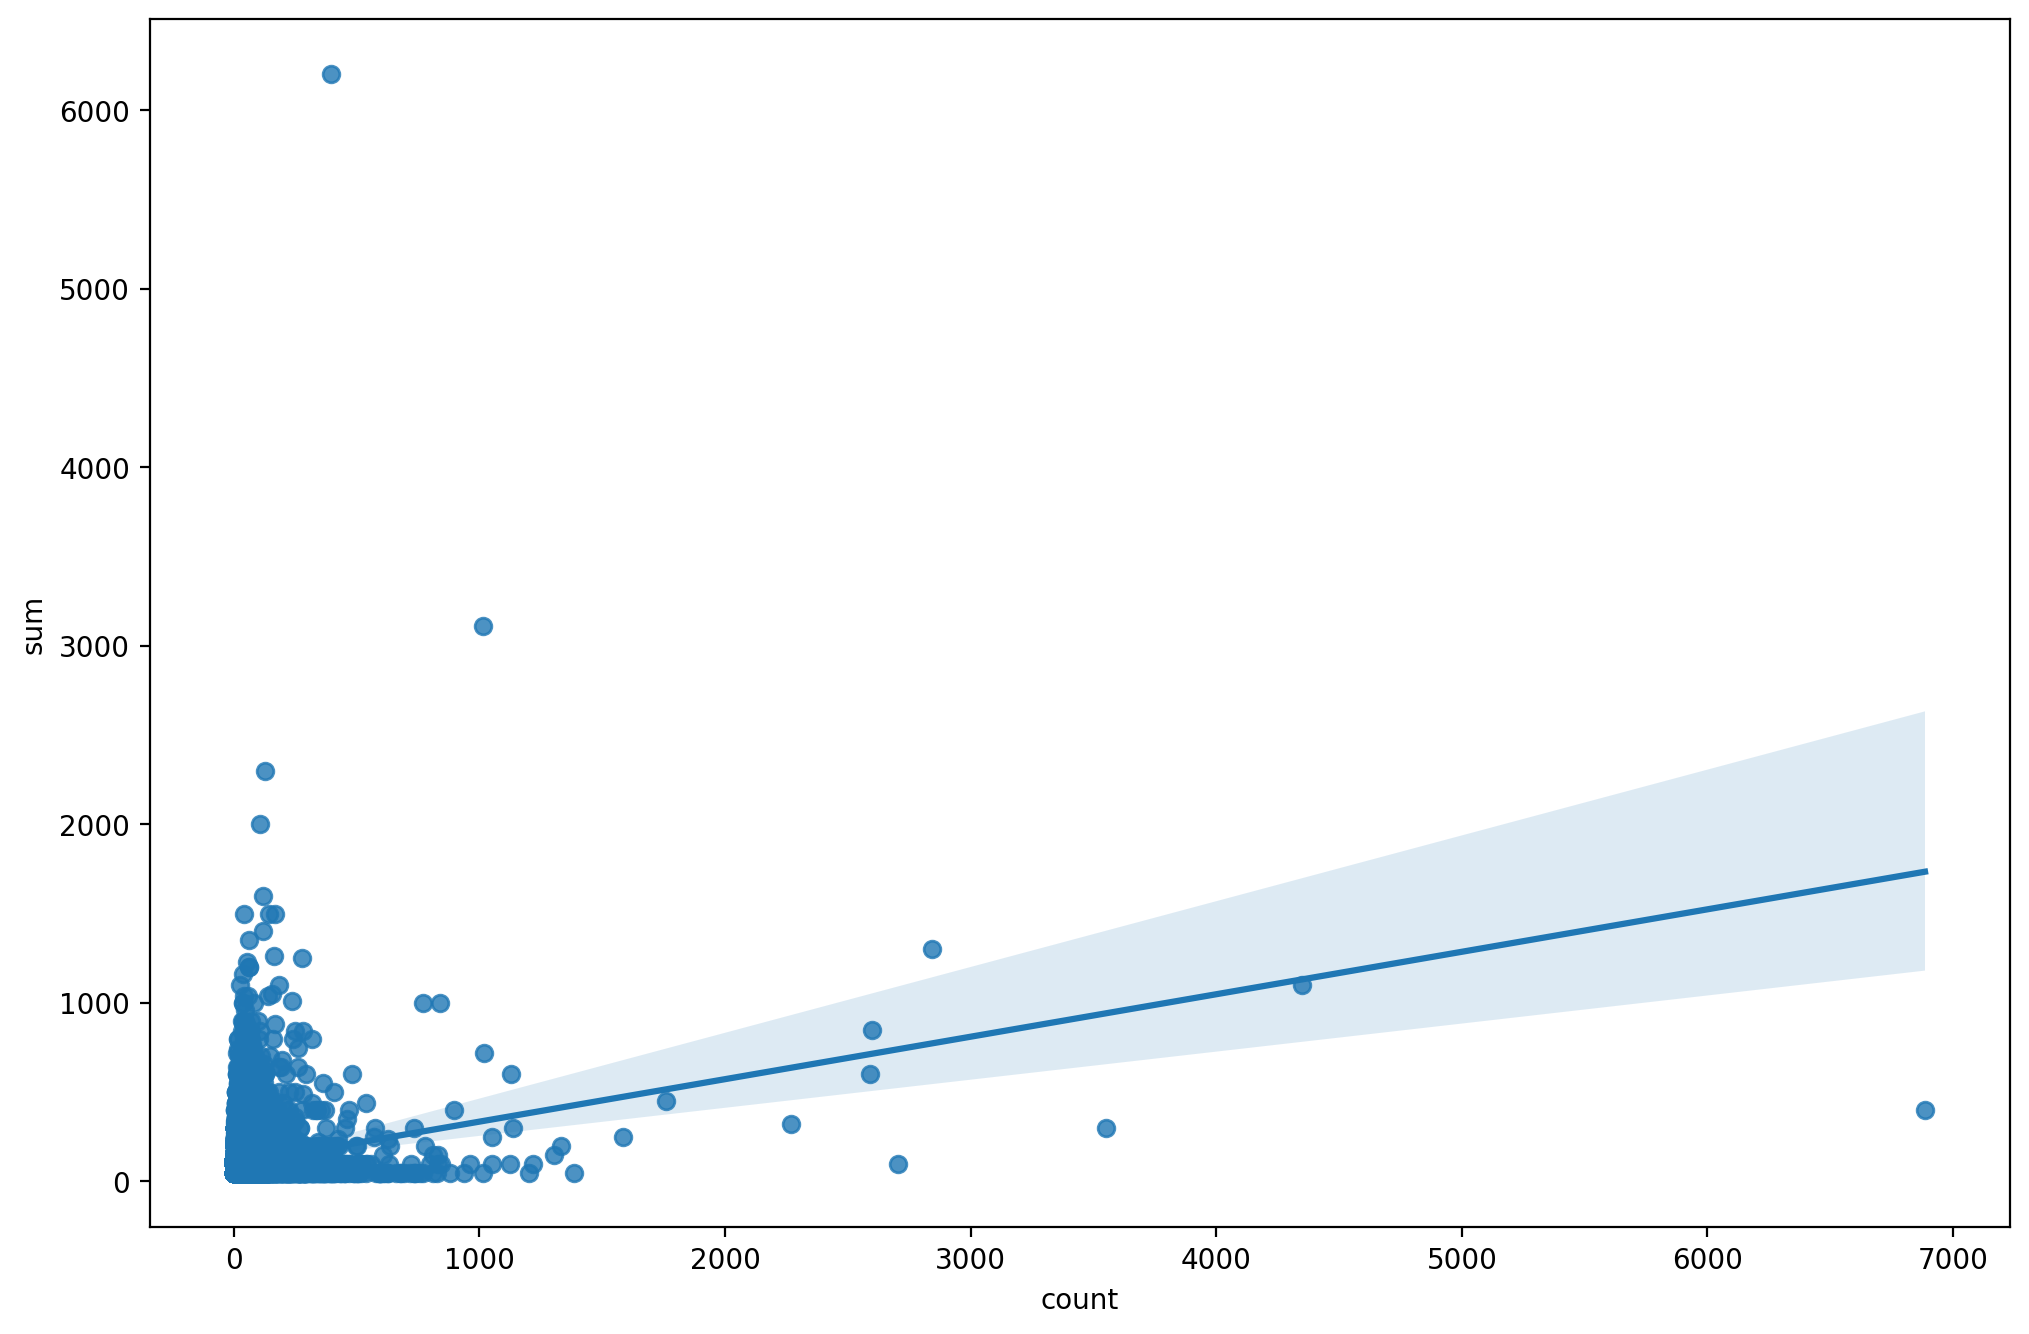

In [234]:
sns.regplot(x = 'event', y = 'value', data =df_value );

We zien wat outliers die de plot vervuilen, deze gaan we verwijderen.

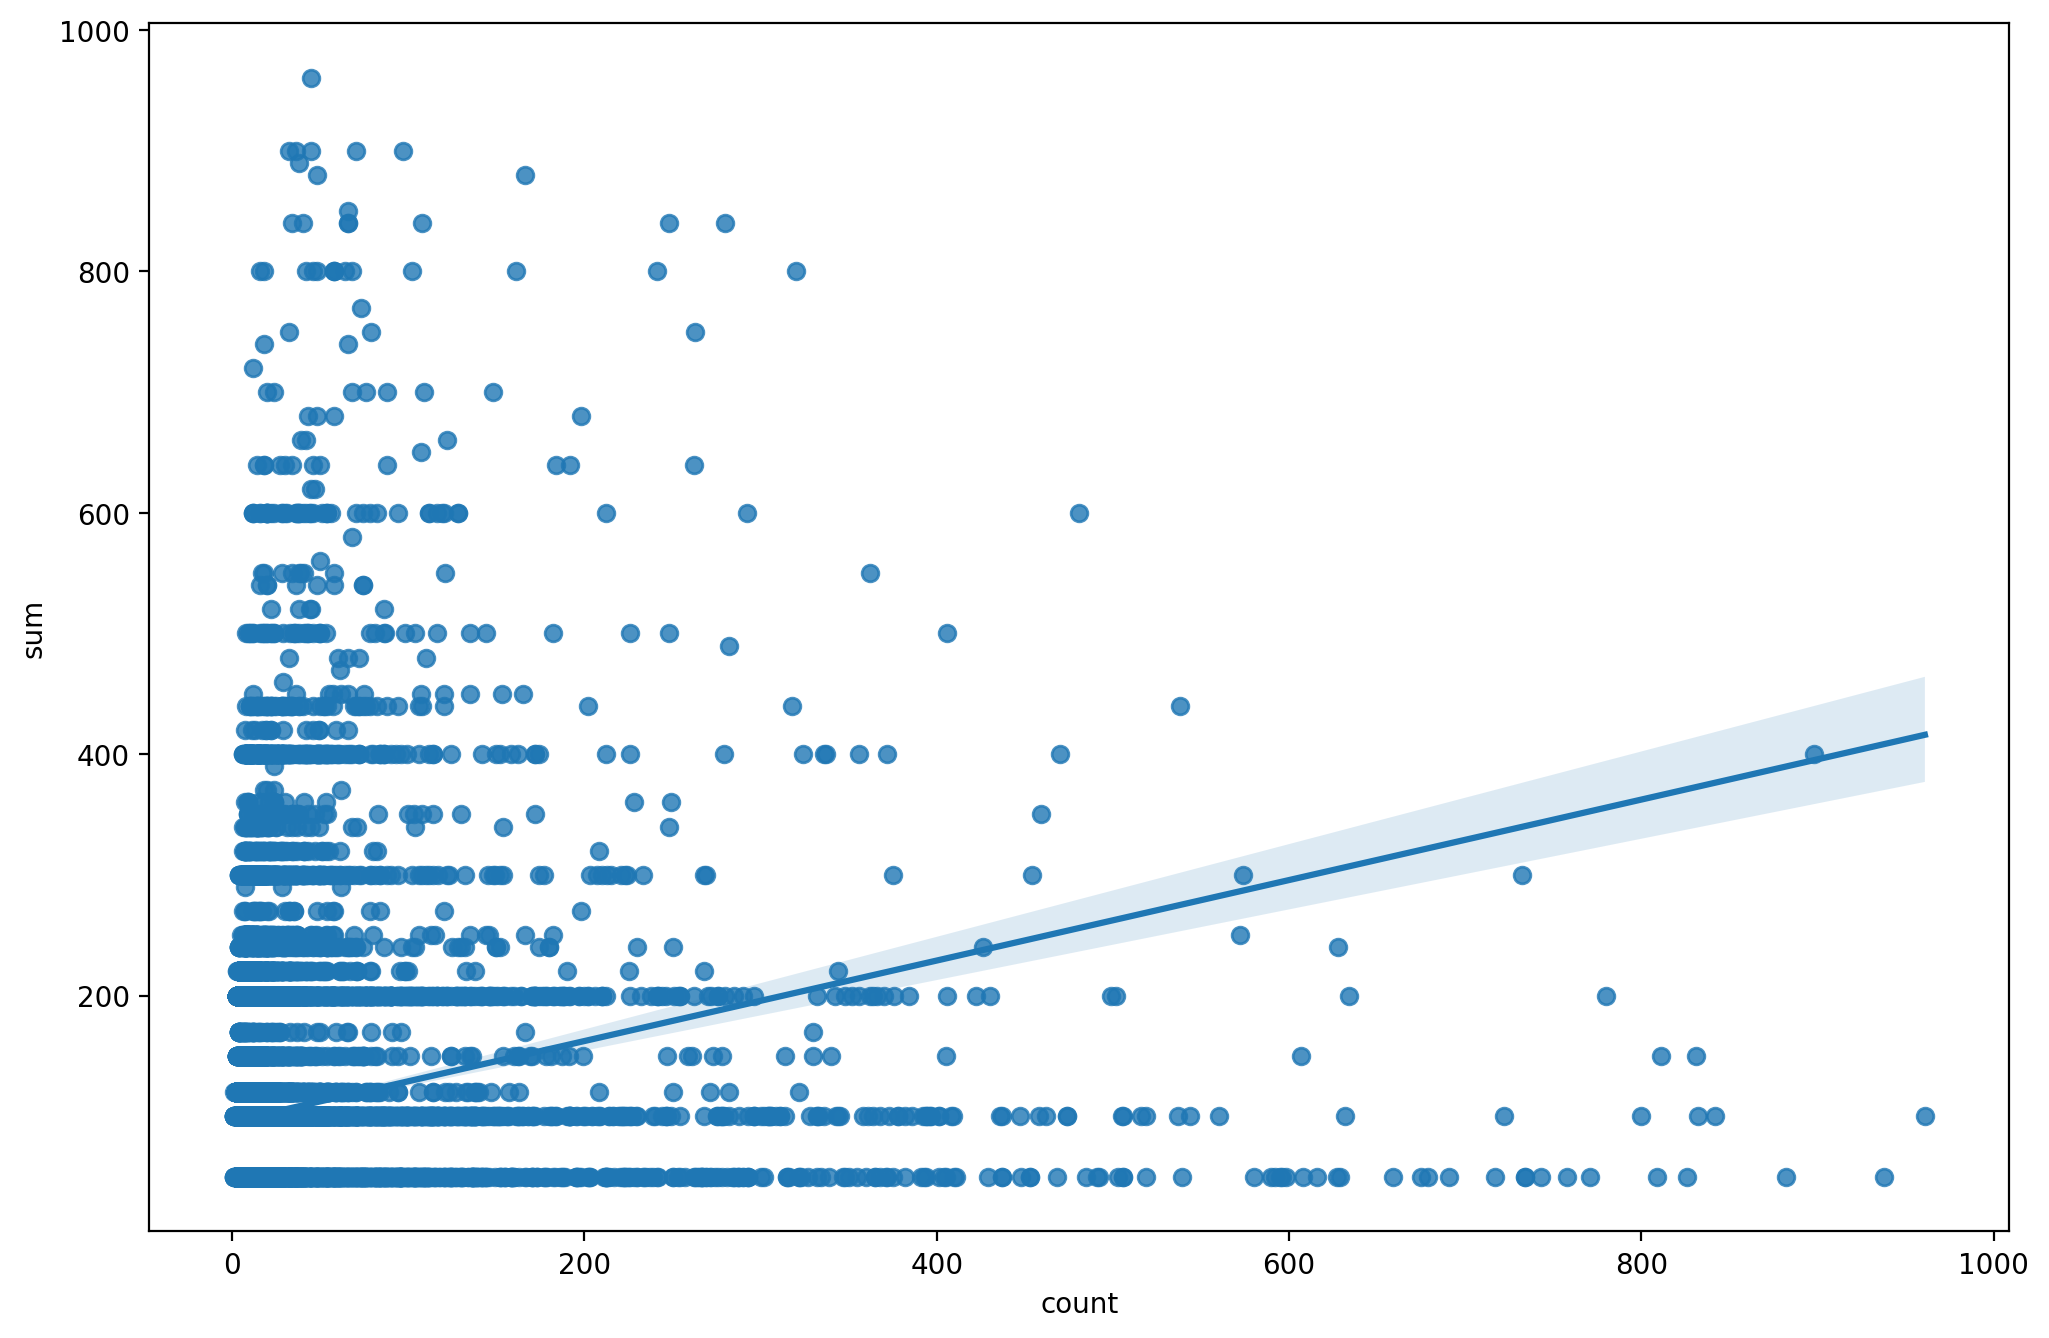

In [235]:
df_value = df_value[df_value['event']['count'] < 1000]
df_value = df_value[df_value['value']['sum'] < 1000]
sns.regplot(x = 'event', y = 'value', data =df_value );

### Antwoord op de vraag

De lijn in de regplot geeft een positief verband aan, maar als we naar de verdeling kijken lijkt het alsof de gebruikers met de minste touchpoints juist de hoogste waardes hebben. Hieruit kunnen we opmaken dat er geen positief verband is tussen het aantal touchpoints en de waarde van de conversie per gebruiker.

## Antwoord op de hoofdvraag
_In hoeverre zijn er inzichten te halen uit de rauwe data van het nieuwe datawarehouse?_

We zien aan de hand van wat simpele analyses er al heel veel verbanden uit zijn te halen. Hierbij hebben we nog niet eens gekeken naar waar de gebruikers vandaan kwamen, de relatie met de omzet en we hebben ons alleen gefocust op marketing activiteiten en niet op sales. Advies voor vervolgonderzoek is dan ook om te kijken of er verbanden te halen zijn die ook betrekking hebben op de revenue, om op financieel niveau uitspraak te kunnen doen waardoor er beter op ROI gestuurd kan worden.
